<a href="https://colab.research.google.com/github/antonysama/Projects_w._time_series/blob/master/DUCs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
install.packages(c('dplyr', 'magrittr','skimr','tidyr','janitor','datetime','readxl','forecast', dependencies = TRUE, repos = "https://cran.rstudio.com/"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“packages ‘TRUE’, ‘https://cran.rstudio.com/’ are not available for this version of R

Versions of these packages for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [64]:
x<-c('dplyr', 'magrittr','skimr','tidyr','janitor','datetime','readxl', 'forecast','ggplot2')
lapply(x, require, character.only = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

In [65]:
data <- read_excel("AER.xlsx", range = "A1:j174")

In [66]:
head(data)  # View the first few rows of the data

Drill_Year,Drill_month,Drilled well,Drilled well and Completed,Crude_bitumen_well_count,Oil_well_count,Gas_well_count,Other_well_count,Connected,Not Connected
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2009,1,1660,460,23,10,262,165,295,165
2009,2,1600,1079,43,20,754,262,817,262
2009,3,490,437,37,18,169,213,224,213
2009,4,113,90,35,3,18,34,56,34
2009,5,137,130,40,6,29,55,75,55
2009,6,337,238,24,10,80,124,114,124


In [79]:
# Combine first and second columns and create a date column
data$date <- as.Date(paste(data$Drill_Year, data$Drill_month, "01", sep = "-"), format = "%Y-%m-%d")
# Create the DUC% field
data$DUC_percent <- (1 - (data$`Drilled well and Completed` / data$`Drilled well`)) * 100
# View the updated data
tail(data)

Drill_Year,Drill_month,Drilled well,Drilled well and Completed,Crude_bitumen_well_count,Oil_well_count,Gas_well_count,Other_well_count,Connected,Not Connected,date,DUC_percent
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>
2022,12,617,590,46,98,65,381,209,381,2022-12-01,4.376013
2023,1,976,461,46,61,33,321,140,321,2023-01-01,52.766393
2023,2,958,649,51,124,72,402,247,402,2023-02-01,32.254697
2023,3,781,617,46,125,60,386,231,386,2023-03-01,20.998720
2023,4,383,344,37,26,43,238,106,238,2023-04-01,10.182768
2023,5,292,265,15,25,5,220,45,220,2023-05-01,9.246575


`geom_smooth()` using formula = 'y ~ x'


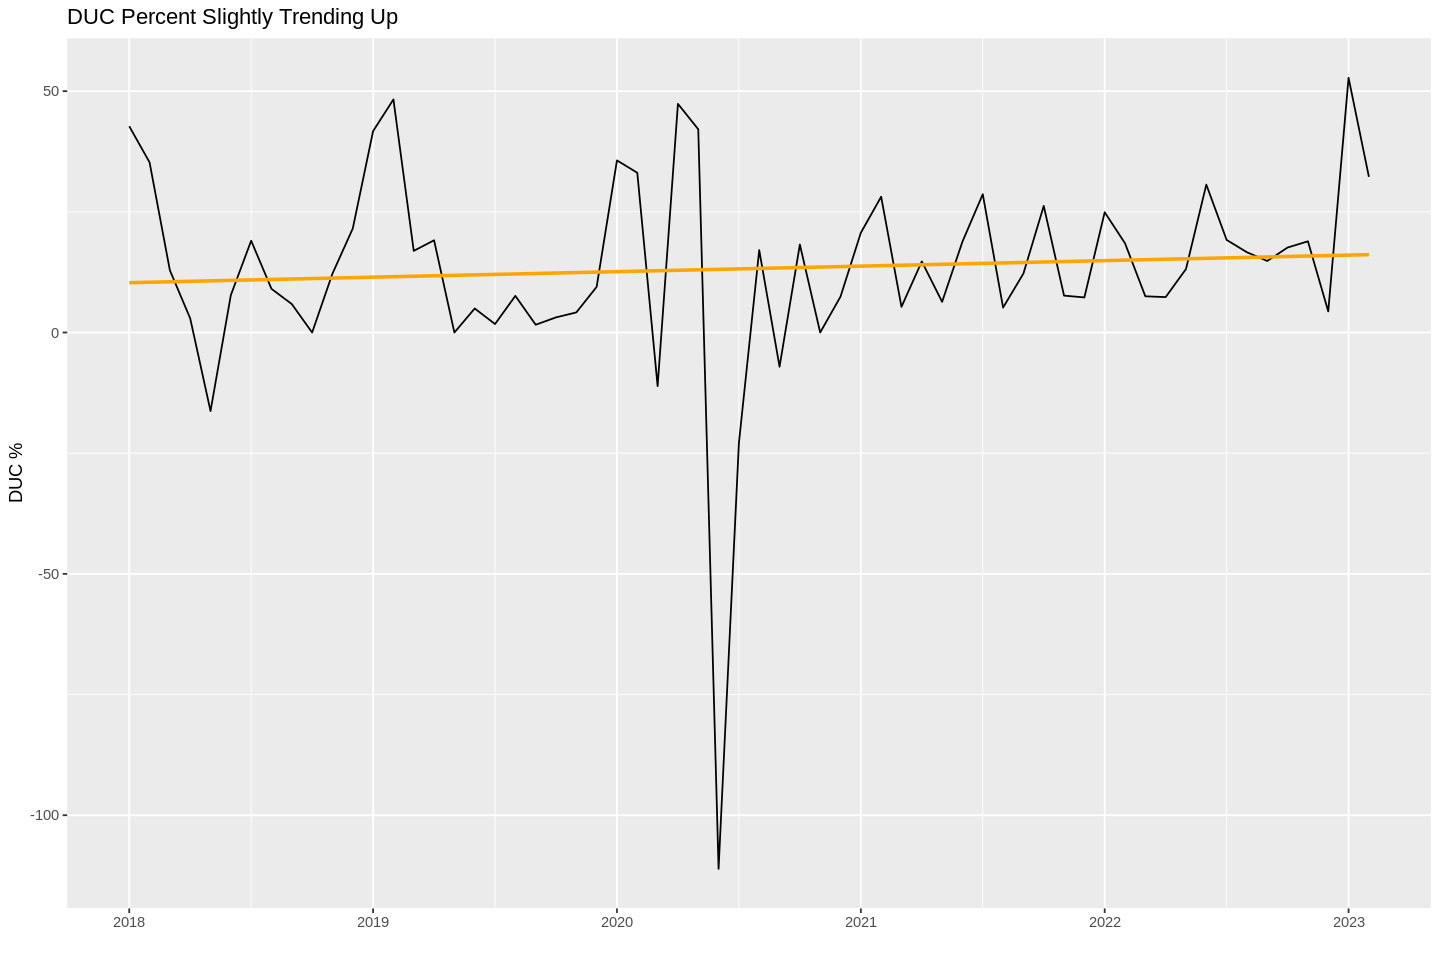

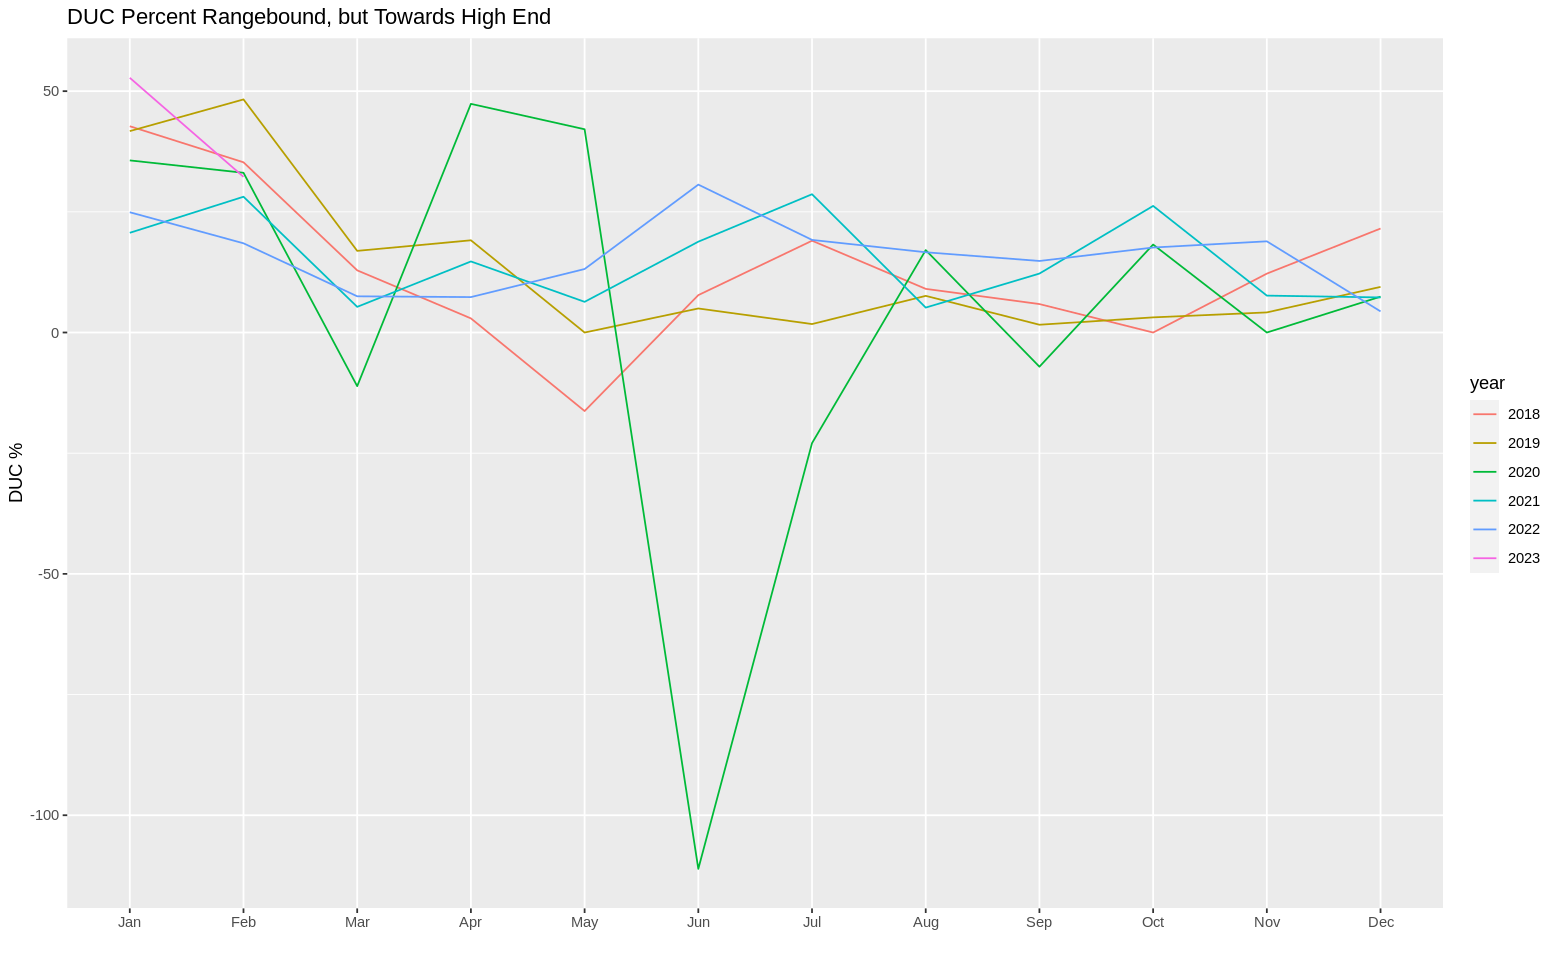

In [116]:
# Creating a time series and plotting seasonality
# Convert the 'date' column to a Date format (if not already done)
data$date <- as.Date(data$date)

# Create a subset for data after 2017 but before 2023-03: create a test set after 2023-03
subset_data <- subset(data, Drill_Year > 2017 & date < as.Date("2023-03-01"))
test_data <- subset(data, Drill_Year > 2017 & date >= as.Date("2023-03-01") & date <= as.Date("2023-05-01"))
# Create a time series object
mydatats <- ts(subset_data$DUC_percent, start = c(2018, 1), frequency = 12)  # Assuming monthly data
testts <- ts(subset_data$DUC_percent, start = c(2023, 3), end= c(2023, 5),frequency = 12)

# Plot the time series
options(repr.plot.width = 12, repr.plot.height = 8)
autoplot(mydatats) +   geom_smooth(method = "lm", se = FALSE, color = "orange") +   labs(title = "DUC Percent Slightly Trending Up", x = "", y = "DUC %")

# Plot the seasonality
options(repr.plot.width = 13, repr.plot.height = 8)
ggseasonplot(mydatats)+labs(title = "DUC Percent Rangebound, but Towards High End", x = "", y = "DUC %")


In [74]:
#Jung-Box Q∗ stat has a p-value of 0.002, meaning not a random series and therefore it is correlated with that of previous months
Box.test(diff(mydatats), lag=10, type="Ljung-Box")


	Box-Ljung test

data:  diff(mydatats)
X-squared = 28.267, df = 10, p-value = 0.001636


In [ ]:
#Unit root test statistic is much bigger than 5% , the null hypothesis is rejected, that is, the data are not stationary
library(urca)
mydatats %>% ur.kpss() %>% summary()


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 0.1276 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [75]:
mydatats %>% diff() %>% ur.kpss() %>% summary() # 1 diff is enough


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 3 lags. 

Value of test-statistic is: 0.0448 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [126]:
(fit <- auto.arima(mydatats, seasonal=FALSE, stepwise=FALSE, approximation=FALSE))

Series: mydatats 
ARIMA(0,0,2) with non-zero mean 

Coefficients:
         ma1      ma2     mean
      0.4122  -0.4828  12.6895
s.e.  0.1147   0.1183   2.3533

sigma^2 = 407.6:  log likelihood = -273.53
AIC=555.05   AICc=555.75   BIC=563.56

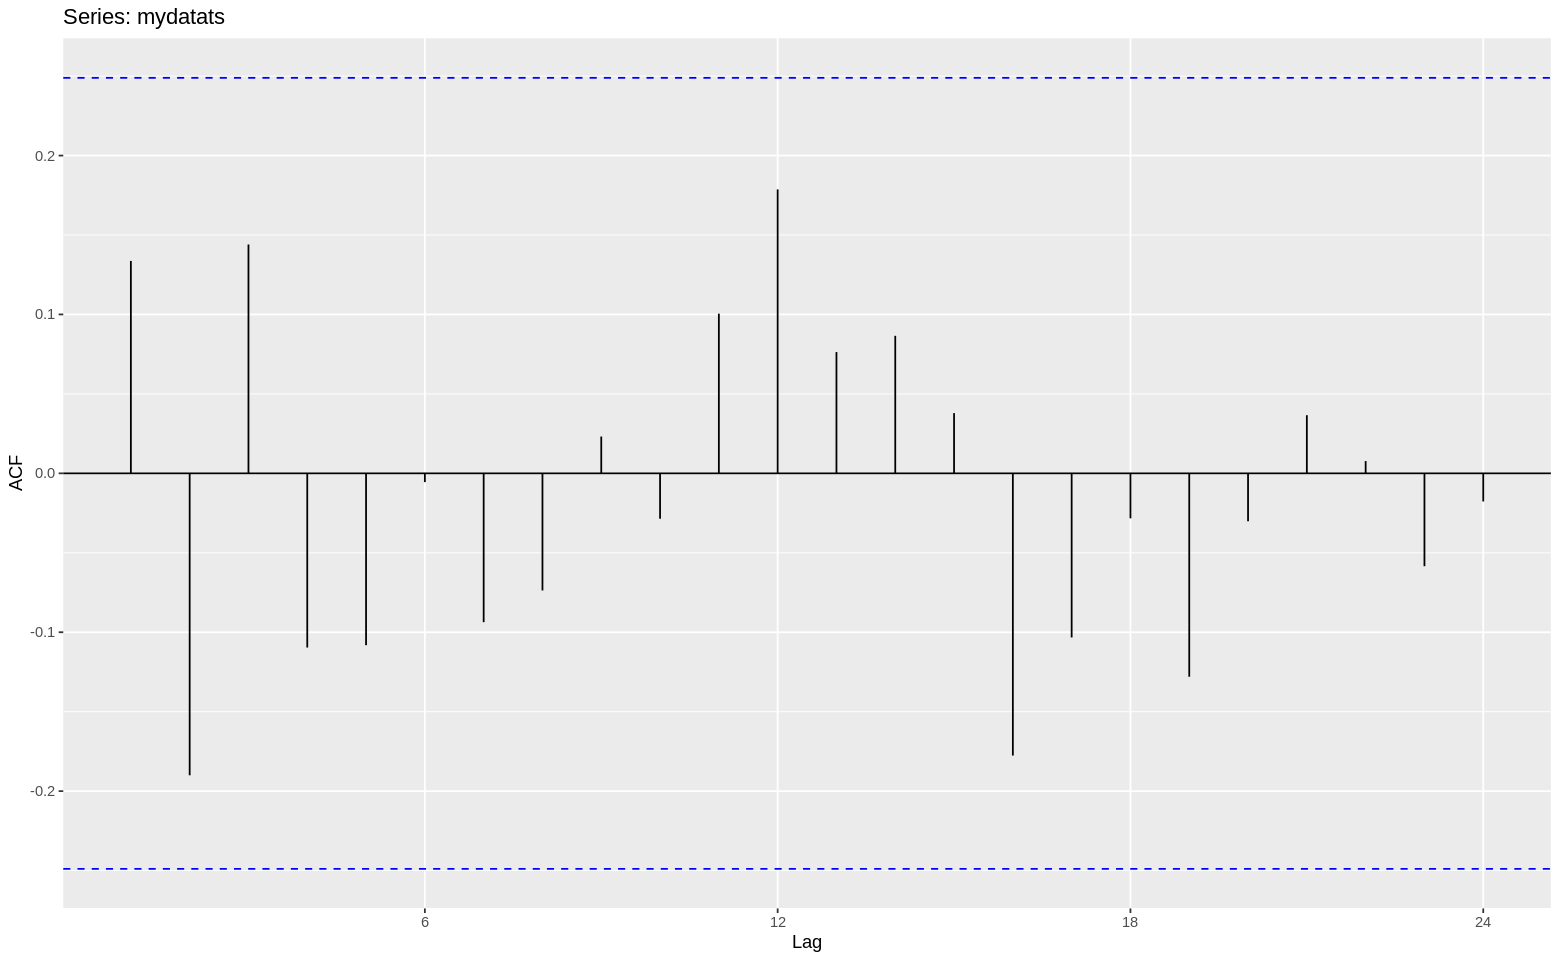

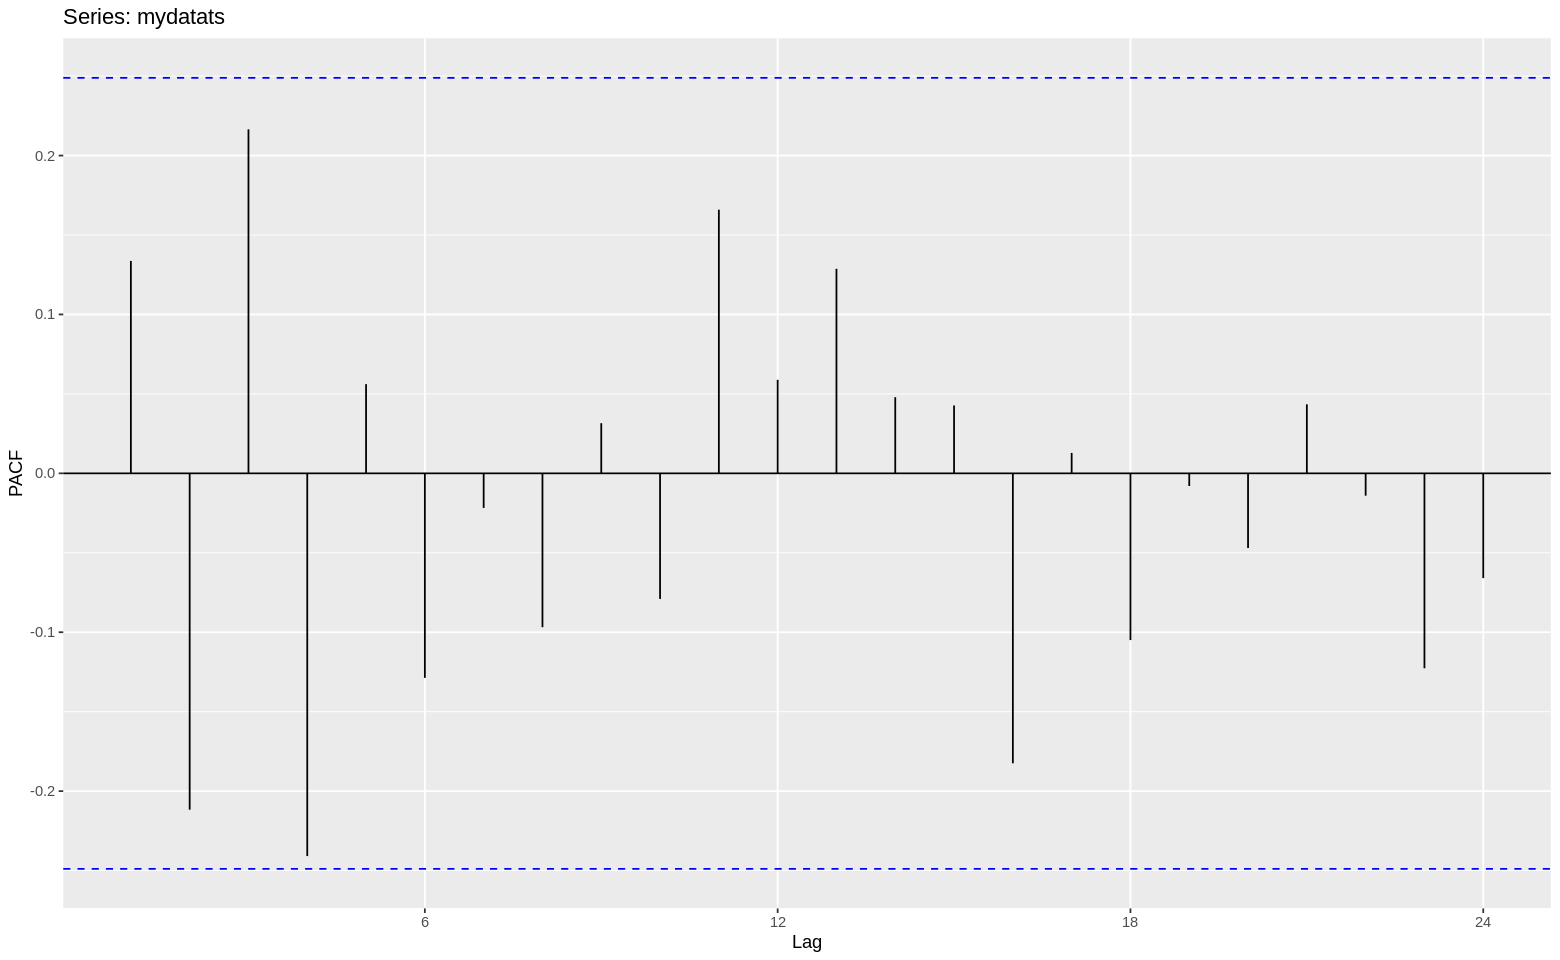

In [127]:
ggAcf(mydatats)
ggPacf(mydatats)

In [128]:
fit %>% forecast(h=3) ##%>% autoplot(include=80)

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Mar 2023      -5.585172 -31.45896 20.28861 -45.15571 33.98537
Apr 2023      11.502057 -16.48322 39.48734 -31.29773 54.30185
May 2023      12.689478 -17.95717 43.33612 -34.18052 59.55948

In [152]:
(fc <- forecast(fit, h= 3))

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Mar 2023      -5.585172 -31.45896 20.28861 -45.15571 33.98537
Apr 2023      11.502057 -16.48322 39.48734 -31.29773 54.30185
May 2023      12.689478 -17.95717 43.33612 -34.18052 59.55948

`geom_smooth()` using formula = 'y ~ x'


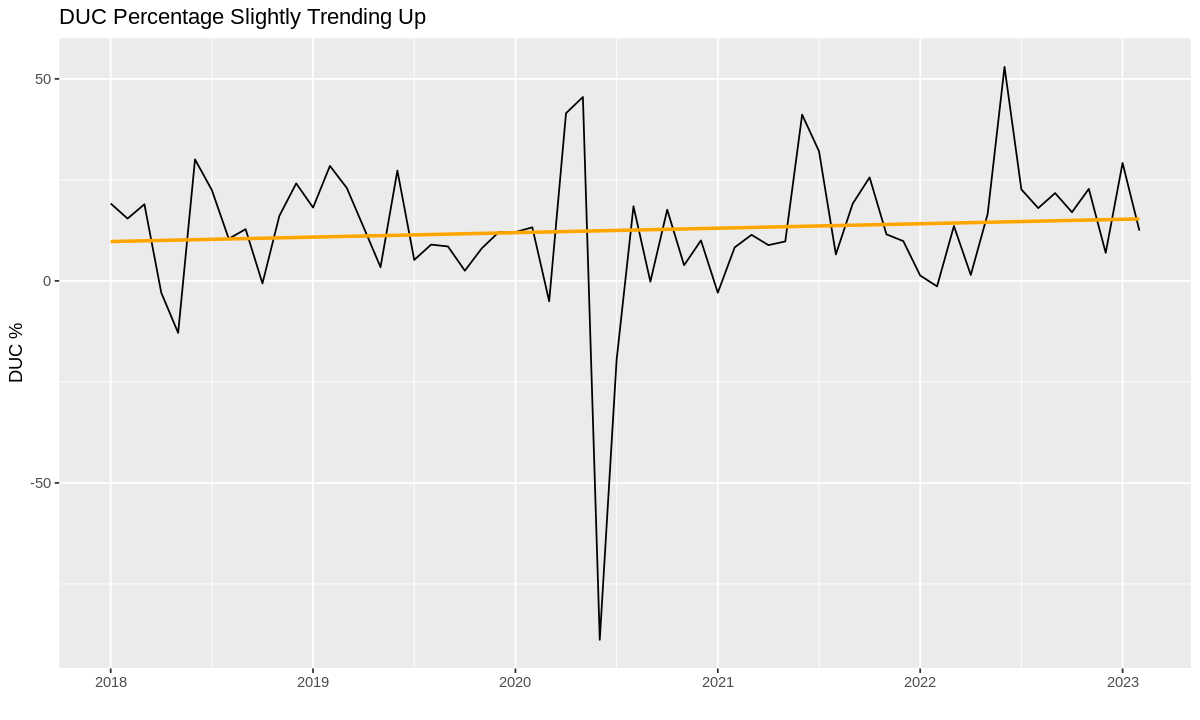

In [129]:
#Seasonal adjustment
mydatats %>% stl(t.window = 13, s.window='periodic') %>% seasadj() -> eeadj

# Plot the time series
options(repr.plot.width = 10, repr.plot.height = 6)
autoplot(eeadj) +   geom_smooth(method = "lm", se = FALSE, color = "orange") +   labs(title = "DUC Percentage Slightly Trending Up", x = "", y = "DUC %")

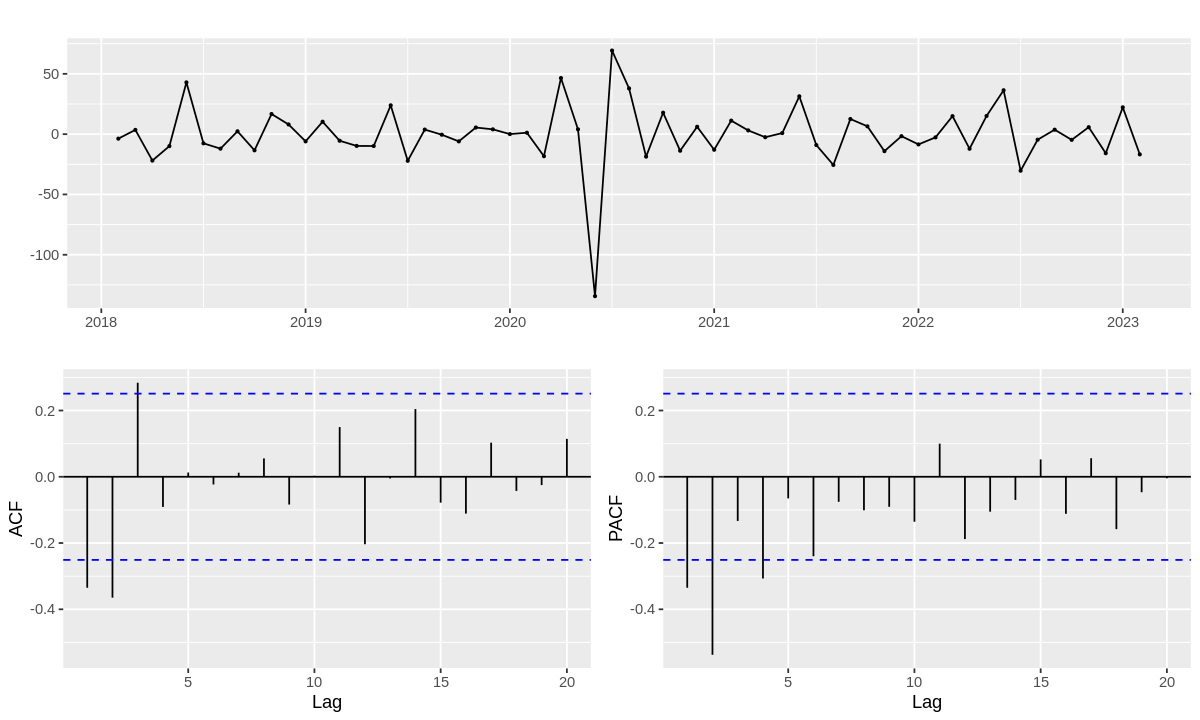

In [130]:
# No change in variance so no Box-Cox transformation,
# But not stationary so we neeed to difference
# ACF is suggestive of an MA(3) PACF suggests AR(4)
eeadj %>% diff() %>% ggtsdisplay(main="")

In [131]:
(fit2 <- Arima(eeadj, order=c(4,1,3)))

Series: eeadj 
ARIMA(4,1,3) 

Coefficients:
         ar1     ar2     ar3     ar4      ma1      ma2     ma3
      0.0870  0.3919  0.1265  0.0664  -0.8022  -0.9551  0.7575
s.e.  0.5374  0.3761  0.1468  0.1391   0.5280   0.1565  0.5014

sigma^2 = 310.3:  log likelihood = -260.54
AIC=537.08   AICc=539.85   BIC=553.97


	Ljung-Box test

data:  Residuals from ARIMA(4,1,3)
Q* = 2.0681, df = 5, p-value = 0.8396

Model df: 7.   Total lags used: 12



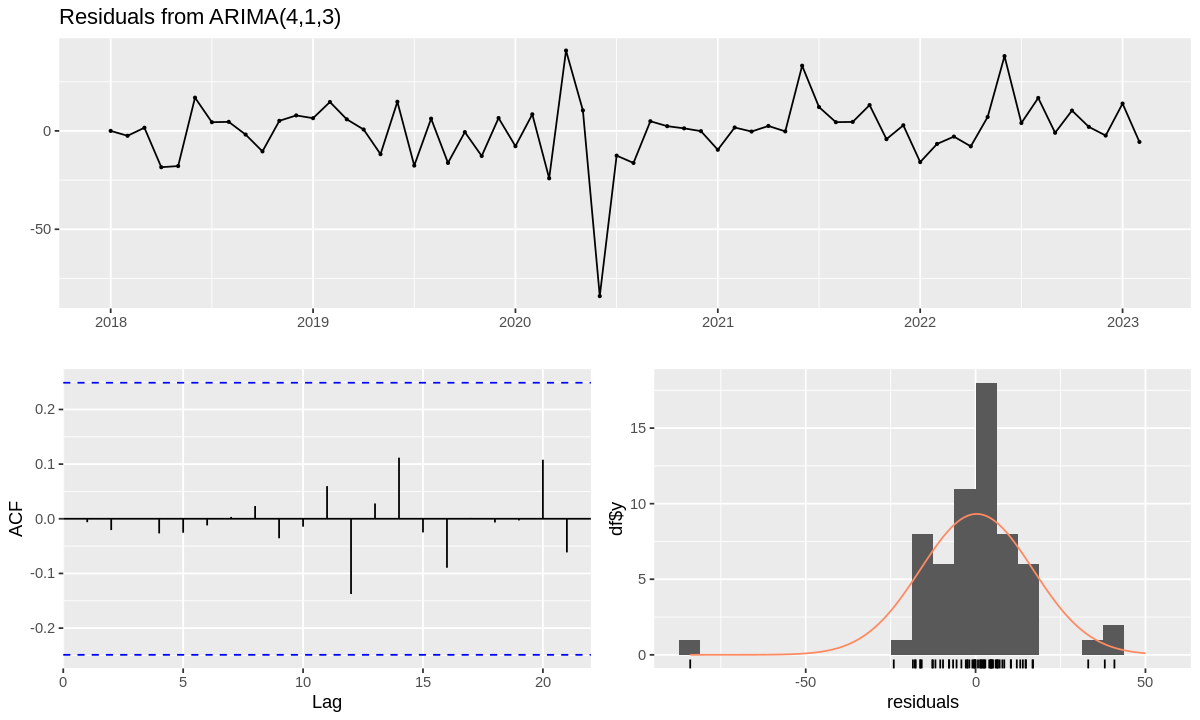

In [132]:
# ACF plot of the residuals from the ARIMA(4,1,3) model shows that all autocorrelations are within the threshold limits,indicating that the residuals are behaving like white noise.
# A portmanteau test returns a large p-value, also suggesting that the residuals are white noise
checkresiduals(fit2)

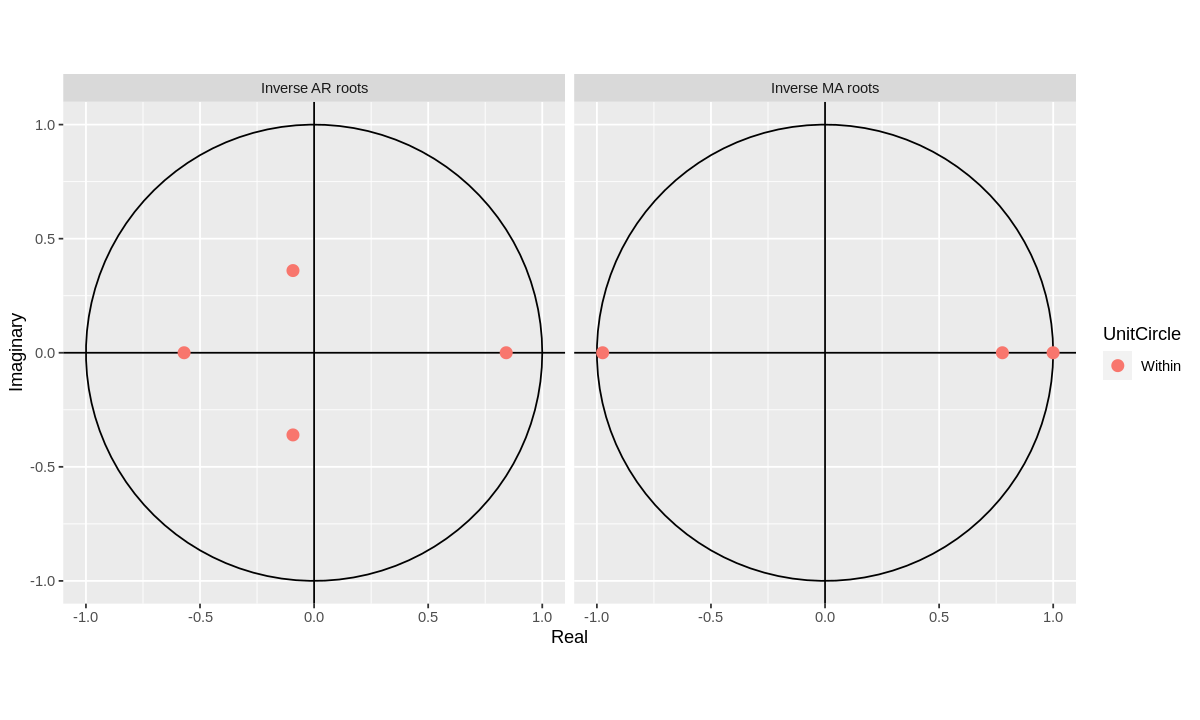

In [133]:
#They are all inside the unit circle, as we would expect because R ensures the fitted model is both stationary and invertible.
autoplot(fit2)

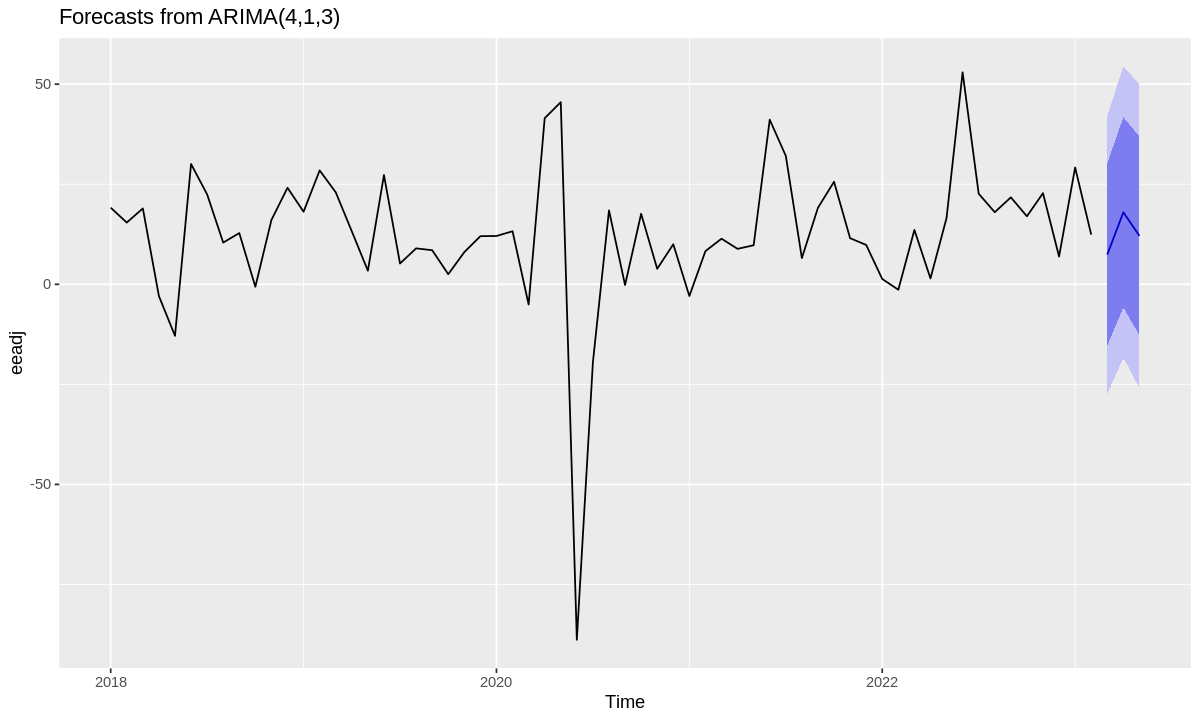

In [134]:
fit2 %>% forecast(h=3) %>% autoplot()

In [151]:
(fc2 <- forecast(fit2, h= 3))

         Point Forecast      Lo 80    Hi 80     Lo 95    Hi 95
Mar 2023       7.423663 -15.343530 30.19086 -27.39575 42.24308
Apr 2023      17.988282  -5.760375 41.73694 -18.33216 54.30872
May 2023      12.101794 -12.739938 36.94353 -25.89036 50.09395

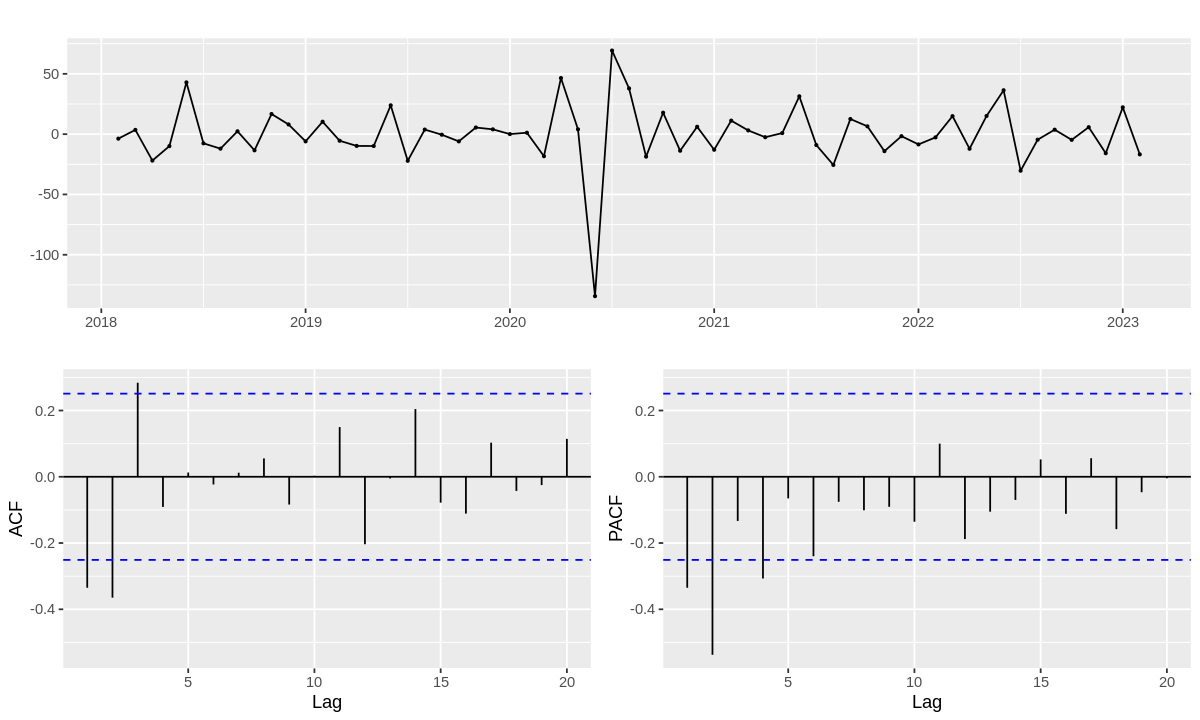

In [139]:
# Taking a seasonal difference (diff (4)) on top of the diff for stationarity (diff)
# Looks like AR 4 & MA (3?)
eeadj %>% diff() %>% ggtsdisplay(main="")

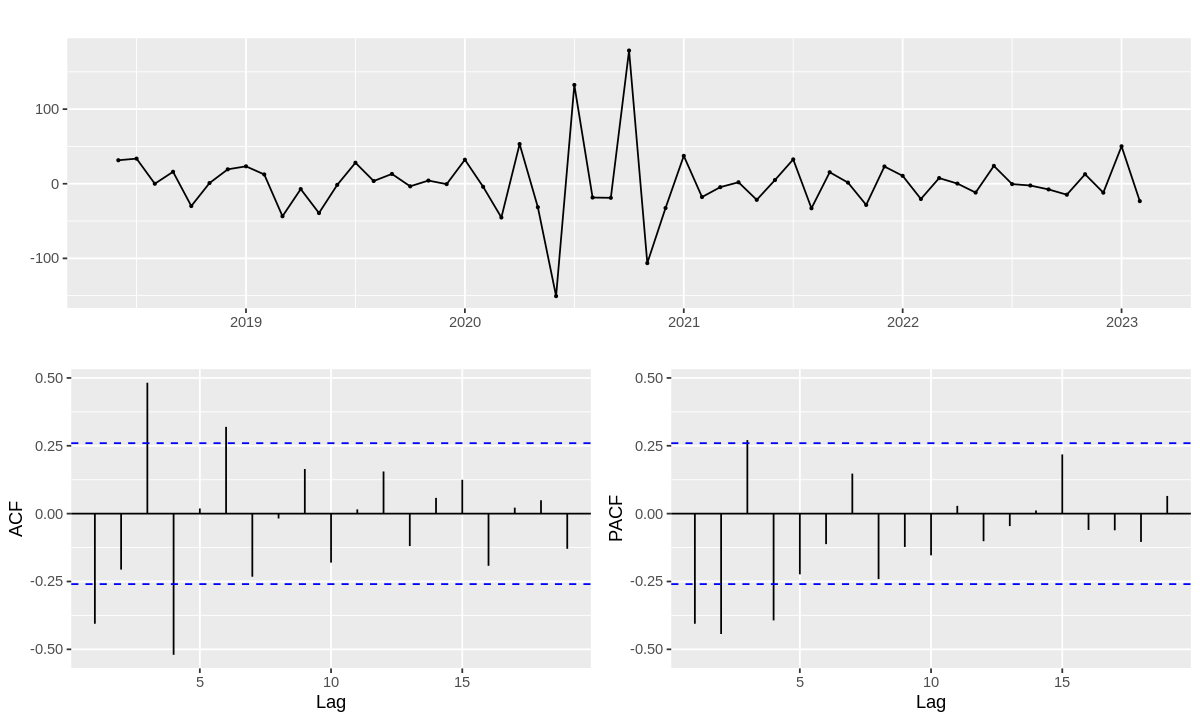

In [140]:
# These also appear to be non-stationary, so we take a first difference
# The significant spike at lag 3 in the ACF suggests a non-seasonal MA(3) component, and the significant spike at lag 4 in the ACF suggests a seasonal MA(1) component.
# The significant spike at lag 3 in the PACF suggests a non-seasonal MA(3) component, and the significant spike at lag 4 in the PACF suggests a seasonal MA(1) component.
 mydatats %>% diff(lag=4) %>% diff()  %>% ggtsdisplay()

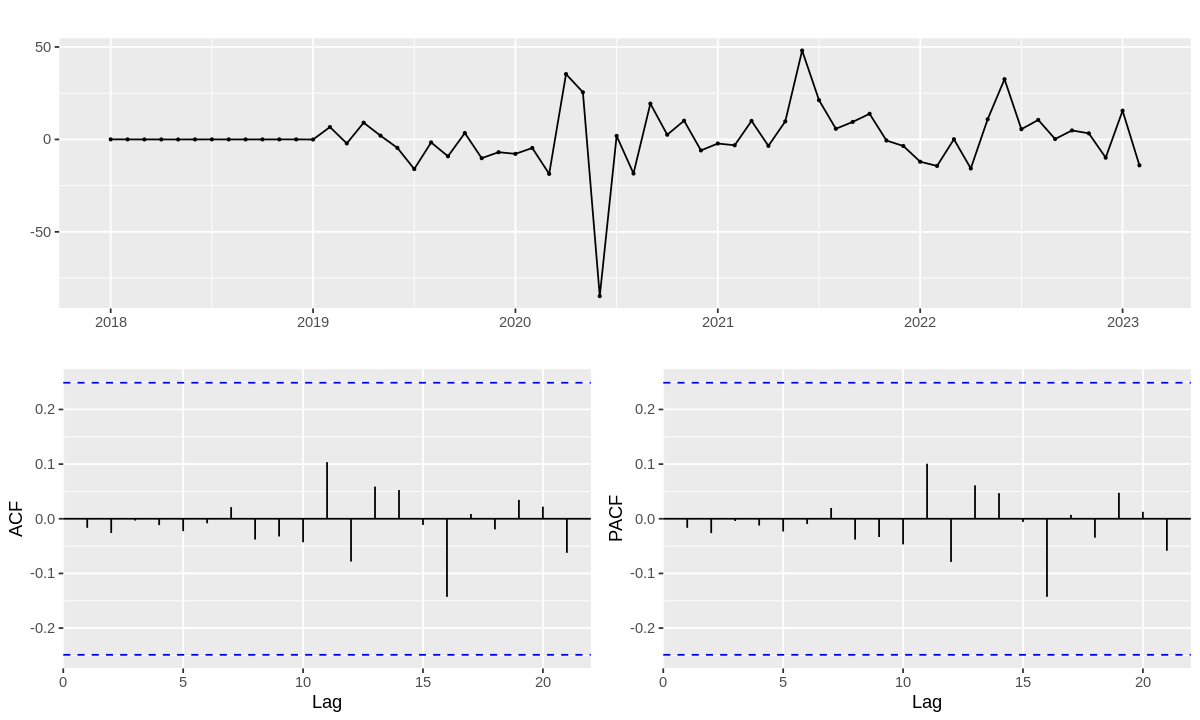

In [141]:
 #ARIMA(3,1,3)(1,1,1) model indicates a seasonal difference, and non-seasonal and seasonal AR() an MA() components
 mydatats %>%
  Arima(order=c(3,1,3), seasonal=c(1,1,1)) %>%
  residuals() %>% ggtsdisplay()

In [142]:
(fit3 <- Arima(mydatats, order=c(4,1,3), seasonal=c(1,1,1)))

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


Series: mydatats 
ARIMA(4,1,3)(1,1,1)[12] 

Coefficients:
          ar1      ar2      ar3      ar4      ma1      ma2     ma3    sar1
      -0.5225  -0.1034  -0.0167  -0.0104  -0.1063  -0.9245  0.1817  0.0491
s.e.      NaN      NaN      NaN      NaN      NaN      NaN     NaN  0.1772
         sma1
      -0.9999
s.e.   0.2819

sigma^2 = 420.3:  log likelihood = -225.04
AIC=470.07   AICc=475.86   BIC=488.99


	Ljung-Box test

data:  Residuals from ARIMA(4,1,3)(1,1,1)[12]
Q* = 1.8696, df = 3, p-value = 0.5999

Model df: 9.   Total lags used: 12



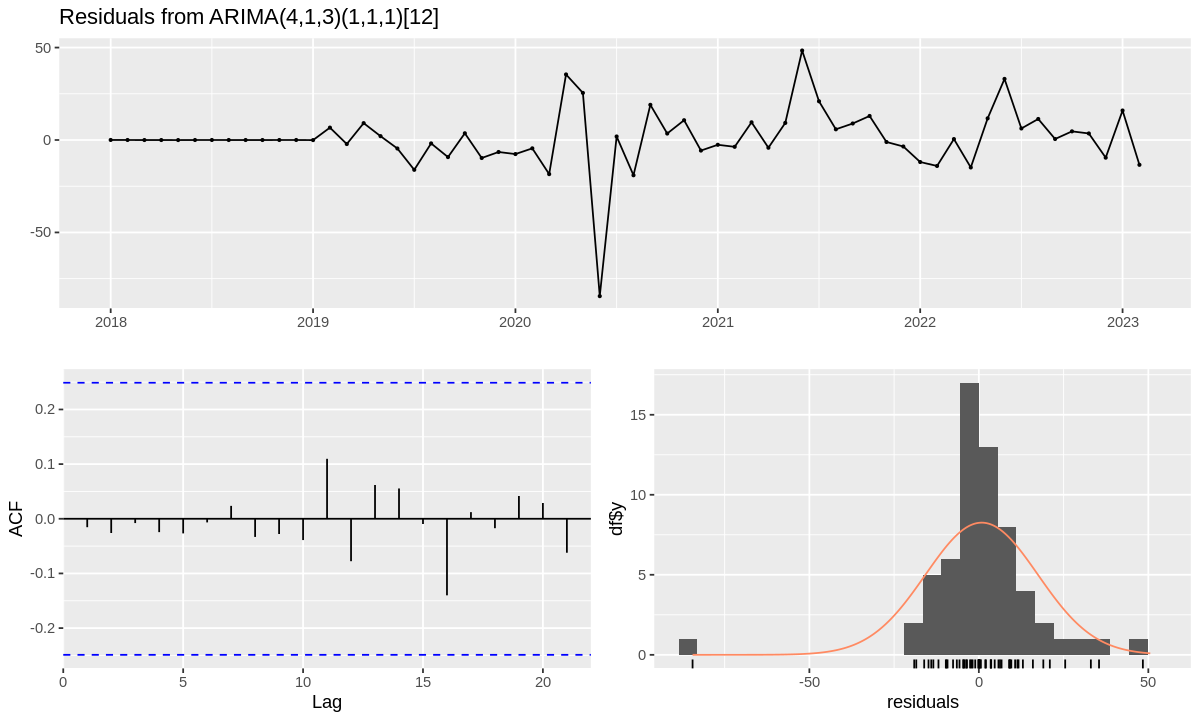

In [143]:
# ACF plot of the residuals from the ARIMA(4,1,3) , seasonal=c(1,1,1) model shows that all autocorrelations are within the threshold limits,indicating that the residuals are behaving like white noise.
# A portmanteau test returns a large p-value, also suggesting that the residuals are white noise. Above AIC is the smallest
checkresiduals(fit3)

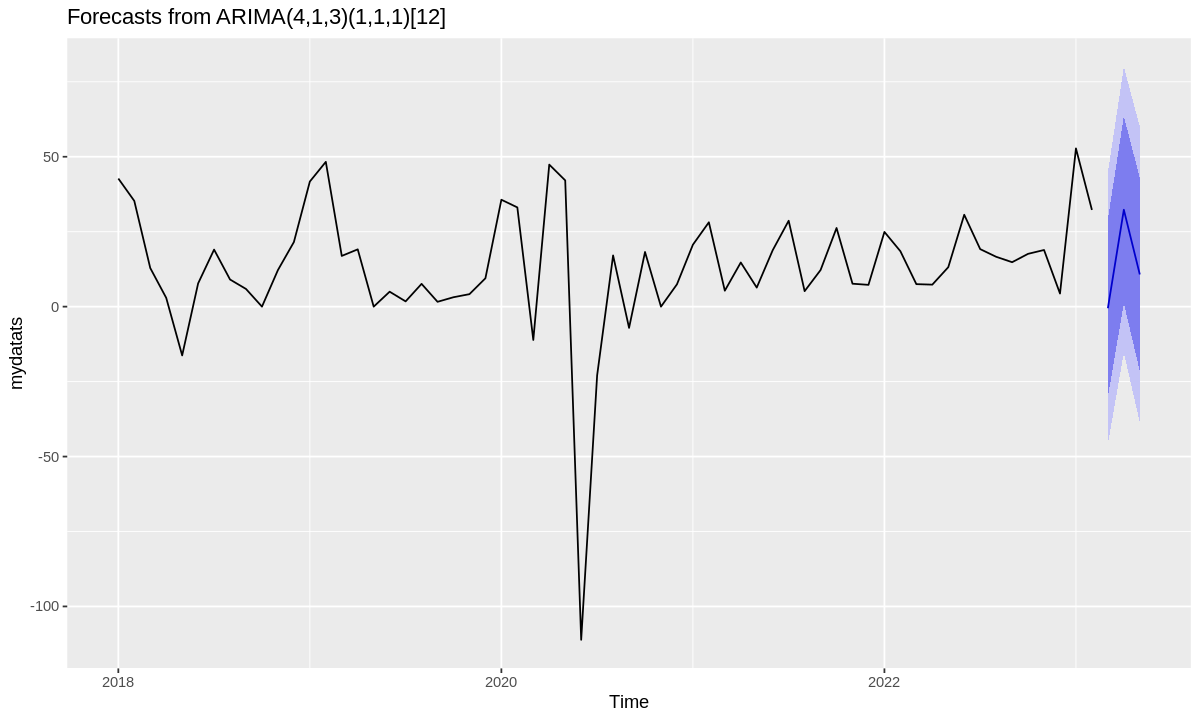

In [144]:
fit3 %>% forecast(h=3) %>% autoplot()

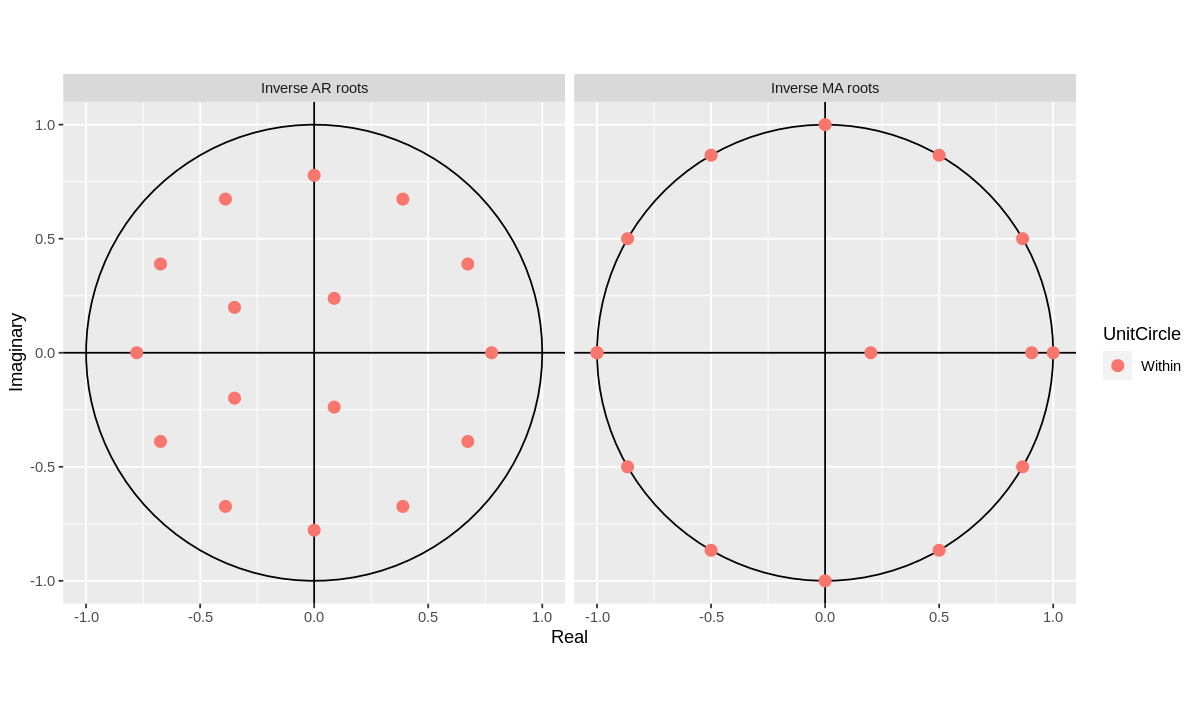

In [145]:
#They are all inside the unit circle, as we would expect because R ensures the fitted model is both stationary and invertible.
autoplot(fit3)

In [146]:
testts

,Mar,Apr,May
2023,42.73381,35.26316,12.88136


In [147]:
(fc3 <- forecast(fit3, h= 3))

         Point Forecast      Lo 80    Hi 80     Lo 95    Hi 95
Mar 2023     -0.5279509 -30.161502 29.10560 -45.84856 44.79265
Apr 2023     32.3109742   1.156508 63.46544 -15.33567 79.95762
May 2023     10.7337614 -21.516993 42.98452 -38.58951 60.05703

In [154]:
accuracy(fc3, test_data$DUC_percent)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.8400031,16.46733,9.517605,NaN,Inf,0.5559573,-0.01540245
Test set,-0.6962407,17.84439,15.047354,-43.62659,111.9694,0.8789697,NA


In [153]:
accuracy(fc2, test_data$DUC_percent)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.3221466,16.440515,10.363747,-8.914896,180.1177,0.6709011,-0.00632279
Test set,0.9714411,9.189859,8.078597,-14.295250,57.3933,0.5229710,NA


In [155]:
accuracy(fc, test_data$DUC_percent)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.2134698,19.69477,12.66211,-Inf,Inf,0.7396393,-0.05549359
Test set,7.2738995,15.49513,10.44869,25.46907,58.92938,0.6103456,NA
